# Анализ данных

In [2]:
import json 
import csv #Запись данных в файл
import pandas as pd
import numpy as np
import re
import os #работа с файлами, папками
import folium #для построения карты

## Подключение к серверам

In [3]:
from clickhouse_driver import Client

In [4]:
# Подключение к серверу
# У нас на Амазоне развернут кластер из двух серверов
client = Client('3.23.248.232', user='default', password='qwerty') # наш первый сервер
#client = Client('3.23.221.144', user='default', password='qwerty') # наш второй сервер

In [5]:
client.execute('SHOW tables from realty_db')

[('.inner.complexes_infr_dist',),
 ('.inner.complexes_infr_summary',),
 ('.inner.complexes_prices',),
 ('.inner.nearest_data',),
 ('clusters_info',),
 ('complexes_info',),
 ('complexes_infr_dist',),
 ('complexes_infr_summary',),
 ('complexes_prices',),
 ('distr_clusters_info',),
 ('distr_complexes_info',),
 ('distr_complexes_infr_dist',),
 ('distr_complexes_infr_summary',),
 ('distr_complexes_prices',),
 ('distr_infr',),
 ('distr_nearest_data',),
 ('distr_offers',),
 ('infr',),
 ('nearest_data',),
 ('offers',)]

## Отбор ЖК в радиусе 35 км от центра

Для дальнейшего анализа мы отбираем ЖК, которые находятся в радиусе 35 км от станции метро Невский проспект. Она имеет координаты `longitude = 30.326892`, `latitude = 59.935368`.

Для удобства дальнейшего использования и возможности автоматического обновления при добавлении новых данных о жилых комплексах, создается materialized view `nearest_data`, который хранит результаты отбора, а расстояние от жк до центра считается с помощью функции `greatCircleDistance`.

In [10]:
# Создание materialized view realty_db.nearest_data
# Запустить необходимо на всех серверах в кластере (у нас их 2)
client.execute('''
create materialized view realty_db.nearest_data
ENGINE = AggregatingMergeTree() 
ORDER BY complex_id 
POPULATE AS SELECT 
complex_id, longitude, latitude,  greatCircleDistance(30.326892, 59.935368, longitude, latitude) as distance 
FROM realty_db.complexes_info WHERE distance < 35000
''')

[]

In [14]:
# Делаем MV realty_db.nearest_data распределенным
client.execute('''create table realty_db.distr_nearest_data as realty_db.nearest_data
ENGINE=Distributed(bd_real_estate_cluster, realty_db, nearest_data)
''')

[]

## Расчет средней стоимости квадратного метра за однокомнатную квартиру в жилых комплексах

Для ЖК, отобранных на предыдущем этапе анализа, мы находим среднюю стоимость за метр квадратный среди однокомнатных квартир. Эта величина будет использоваться в дальнейшем для нахождения ценовых сегментов жилых комплексов.

Для удобства дальнейшего использования и возможности автоматического обновления при добавлении новых данных, создается materialized view `complexes_prices`, который хранит результаты отбора.

In [18]:
# Создание materialized view realty_db.complexes_prices
# Запустить необходимо на всех серверах в кластере (у нас их 2)
client.execute('''create materialized view realty_db.complexes_prices
engine=AggregatingMergeTree() 
order by complex_id 
populate as 
select * from 
(select nc.complex_id as complex_id, nc.longitude as longitude, 
nc.latitude as latitude, AVG(of.price_for_meter) as avg_price_for_meter 
from realty_db.nearest_data as nc ALL LEFT JOIN realty_db.offers as of USING complex_id 
GROUP BY complex_id, longitude, latitude) 
WHERE avg_price_for_meter <> 0;
''')

[]

In [22]:
# Делаем MV realty_db.complexes_prices распределенным
client.execute('''create table realty_db.distr_complexes_prices as realty_db.complexes_prices 
ENGINE=Distributed(bd_real_estate_cluster, realty_db, complexes_prices)
''')

[]

## Подсчет расстояний между жилыми комплексами и объектами инфраструктуры

Для ЖК, отобранных на предыдущем этапе анализа, мы находим расстояния до всех объектов инфраструктуры с помощью функции `greatCircleDistance`. Полученная информация будет использована в дальнейшем для получения информации о количестве объектов инфраструктуры разных категорий в пешей доступности от ЖК.

Для удобства дальнейшего использования и возможности автоматического обновления при добавлении новых данных, создается materialized view `complexes_infr_dist`, который хранит результаты отбора.

In [26]:
# Создание materialized view realty_db.complexes_infr_dist
# Запустить необходимо на всех серверах в кластере (у нас их 2)
client.execute('''CREATE MATERIALIZED VIEW realty_db.complexes_infr_dist 
ENGINE = MergeTree() 
PARTITION BY object_category 
ORDER BY complex_id 
POPULATE AS 
SELECT compl.complex_id as complex_id, infr.com_id as object_id, infr.our_category as object_category, 
greatCircleDistance(compl.longitude, compl.latitude, infr.longitude, infr.latitude) as distance 
FROM realty_db.complexes_prices as compl, realty_db.infr as infr;
''')

[]

In [30]:
# Делаем MV realty_db.complexes_infr_dist распределенным
client.execute('''CREATE TABLE realty_db.distr_complexes_infr_dist as realty_db.complexes_infr_dist 
ENGINE=Distributed(bd_real_estate_cluster, realty_db, complexes_infr_dist)
''')

[]

## Подсчет суммарного количества объектов инфраструктуры в радиусе 1500 м от жилого комплекса

В качестве показателя развития инфраструктуры в определенном географическом районе города будет выступать количество объектов инфраструктуры разного типа, которые находятся в пешей доступности от ЖК.

Для их подсчета создается materialized view `complexes_infr_summary`, который хранит результаты вычисления количества инфраструктурных объектов в радиусе 1,5 км для каждой категории объектов (например, школы или рестораны).

In [34]:
# Создание materialized view realty_db.complexes_infr_summary
# Запустить необходимо на всех серверах в кластере (у нас их 2)
client.execute('''CREATE MATERIALIZED VIEW realty_db.complexes_infr_summary 
ENGINE = AggregatingMergeTree() 
PARTITION BY object_category 
ORDER BY complex_id POPULATE AS 
SELECT complex_id, object_category, count(object_id) as total_object_num 
FROM realty_db.complexes_infr_dist 
WHERE distance < 1500 
GROUP BY complex_id, object_category 
ORDER BY complex_id;
''')

[]

In [38]:
# Делаем MV realty_db.complexes_infr_summary распределенным
client.execute('''CREATE TABLE realty_db.distr_complexes_infr_summary as realty_db.complexes_infr_summary 
ENGINE=Distributed(bd_real_estate_cluster, realty_db, complexes_infr_summary)
''')

[]

## Объединение жилых комплексов в географические кластеры

Уровень цен и развития инфраструктуры сильно меняются в зависимости от района, где находится жилой комплекс. Поэтому для дальнейшего анализа мы объединяем отдельные ЖК в кластеры и проводим анализ уровня развития инфраструктуры и стоимости жилья для полученных кластеров.

Для кластеризации используется информация из materialized view `distr_complexes_prices`, а сама кластеризация производится по методу k-means, с использованием реализации этого метода из библиотеки `scikit-learn`.

In [39]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

In [40]:
# Сохраняем информацию об отобранных ЖК в DataFrame
geo, columns = client.execute('select complex_id, longitude, latitude from realty_db.distr_complexes_prices', with_column_types=True)
geo_df = pd.DataFrame(geo, columns=[tuple[0] for tuple in columns]).set_index('complex_id')
geo_df

,longitude,latitude
complex_id,,
1743,30.335373,60.074814
5630,30.509611,59.864845
5665,30.520393,59.905045
5673,30.312796,60.069901
5674,30.428726,60.055283
...,...,...
869827,30.331354,59.897446
1276125,30.157072,59.840370
1330342,30.341740,59.851494


In [41]:
# Делаем нормализацию для кластеризации
standardisedX_geo = scale(geo_df)
standardisedX_geo = pd.DataFrame(standardisedX_geo, index=geo_df.index, columns=geo_df.columns)

In [42]:
# Кластеризуем ЖК на 55 кластеров (количество кластеров было подобрано эмпирически под нашу задачу)
model_geo55 = KMeans(n_clusters = 55)
model_geo55.fit(standardisedX_geo)
predictions_geo55 = model_geo55.predict(standardisedX_geo)

# Добавляем информацию о кластерах в DataFrame 
geo_df['cluster'] = predictions_geo55

## Сокращение размерности данных об инфраструктурных объектах методом главных компонент (PCA)

Чтобы получить одну переменную, которая характеризовала бы уровень инфраструктуры, мы сокращаем размерность данных методом главных компонент. Для этого мы используем его реализацию из библиотеки `scikit-learn`.

In [48]:
from sklearn.decomposition import PCA

In [52]:
# Сохраняем информацию о количестве инфраструктурных объектов в пешей доступности в DataFrame
result, columns = client.execute('SELECT * FROM realty_db.distr_complexes_infr_summary ORDER BY complex_id', with_column_types=True)
infro_sum_df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

# Преобразовываем DataFrame для удобства дальнейшего анализа
infr_df_reverse = pd.pivot_table(infro_sum_df, values='total_object_num', index=['complex_id'],
                    columns=['object_category']).fillna(0)
infr_df_reverse = infr_df_reverse.rename(columns={"аптека": "pharmacy", "больница": "hospital", 
                         "дрогери": "drogery", "кафе и ресторан": "restaurant", "метро": "subway", 
                         "парк": "park", "пекарня": "bakery",  "супгип": "markets",  "транспорт": "transport",
                         "фитнес": "fitness",  "школа": "school"})

In [53]:
# Выбираем только поля, содержащие инфраструктурные переменные для метода главных компонент
infro_pca_df = infr_df_reverse[["pharmacy","hospital", "drogery", "restaurant", "subway", "park", "bakery", "markets",
                         "transport", "fitness", "school"]]

In [54]:
# Применяем метод главных компонент к нашим подготовленным данным
pca = PCA(n_components = 1)
XPCAreduced = pca.fit_transform(infro_pca_df)
print('Explained variance: ', pca.explained_variance_ratio_[0])

Explained variance:  0.7230693821253514


In [55]:
# Для удобства дальнейшего анализа, сдвигаем результат на отрезок [0, 4]
shifted_xpca = []
delta = XPCAreduced.max() - XPCAreduced.min()
for i in range(len(XPCAreduced)):
    shifted_xpca.append((XPCAreduced[i][0] - XPCAreduced.min()) * 4 / delta )

In [56]:
# Дабавляем в DataFrame значение переменной инфраструктуры, полученной методом главных компонент
infr_df_reverse['pca_infr_comp'] = shifted_xpca
infr_df_reverse

object_category,pharmacy,hospital,drogery,restaurant,subway,park,bakery,markets,transport,fitness,school,pca_infr_comp
complex_id,,,,,,,,,,,,
96,4.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,9.0,4.0,1.0,0.107508
1743,11.0,0.0,3.0,14.0,1.0,0.0,11.0,9.0,20.0,11.0,4.0,0.436819
3126,12.0,2.0,0.0,27.0,1.0,1.0,15.0,11.0,49.0,5.0,7.0,0.748494
5114,0.0,0.0,3.0,4.0,0.0,0.0,2.0,1.0,1.0,1.0,2.0,0.071226
5190,7.0,0.0,0.0,3.0,0.0,0.0,5.0,8.0,9.0,1.0,1.0,0.145065
...,...,...,...,...,...,...,...,...,...,...,...,...
1327970,1.0,0.0,0.0,4.0,0.0,0.0,1.0,3.0,3.0,3.0,0.0,0.088841
1330342,18.0,1.0,6.0,37.0,2.0,2.0,24.0,22.0,62.0,18.0,10.0,1.099186
1342441,24.0,5.0,19.0,53.0,2.0,0.0,28.0,15.0,56.0,19.0,10.0,1.314930


In [57]:
# Статистика по значениям новой переменной инфраструктуры
infr_df_reverse['pca_infr_comp'].describe()

count    407.000000
mean       0.610724
std        0.595857
min        0.000000
25%        0.147562
50%        0.483248
75%        0.844783
max        4.000000
Name: pca_infr_comp, dtype: float64

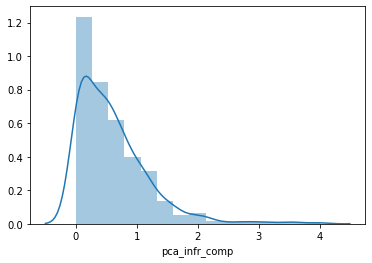

In [59]:
import seaborn as sns

%matplotlib inline

# График распределения значений новой переменной инфраструктуры
sns.distplot(infr_df_reverse['pca_infr_comp'], bins = 15, kde=True, norm_hist=True, label=f'New variable')

In [60]:
# Добавляем суммарную инфраструктуру в DataFrame с кластерами
geo_df['sum_infr'] = infr_df_reverse['pca_infr_comp']
geo_df = geo_df.fillna(0)

## Разделение кластеров по ценовым сегментам

После кластеризации мы анализируем полученные географические районы. Для каждого из таких районов мы определяем ценовой сегмент на основе данных о средней стоимости квадратного метра в однокомнатных квартирах ЖК, которые там находятся.

Данные о средней стоимости квадратного метра берутся из materialized view `distr_complexes_prices`, а для разделения на ценовые сегменты используется `Gaussian Mixture Model`, параметры которой подбираются с целью оптимизировать Байесовский критерий.

In [67]:
from sklearn import mixture

In [61]:
# Загружаем информацию о средней стоимости однокомнатных квартир в ЖК за метр квадратный
price, columns = client.execute('SELECT * FROM realty_db.distr_complexes_prices', with_column_types=True)
complex_avg_df = pd.DataFrame(price, columns=[tuple[0] for tuple in columns]).set_index('complex_id')
complex_avg_df

,longitude,latitude,avg_price_for_meter
complex_id,,,
1743,30.335373,60.074814,107537.217119
5630,30.509611,59.864845,109988.053571
5665,30.520393,59.905045,125942.500000
5673,30.312796,60.069901,112746.300000
5674,30.428726,60.055283,117847.600000
...,...,...,...
869827,30.331354,59.897446,147323.940154
1276125,30.157072,59.840370,112227.049180
1330342,30.341740,59.851494,100039.666667


In [68]:
# Функция, которая по переданным данным подбирает оптимальные параметры для gaussian mixture model, 
# применяет модель на переданных данных и возвращает присвоенные метки 
# Параметры n_components_min и n_components_max - это минимальное и максимальное значения 
# допустимого количества компонент в разбиении. В этих пределах будет идти поиск оптимального
def apply_gaussian_mixture(input_data, n_components_min, n_components_max):
    X = input_data.transpose()
    
    # Gaussian mixture
    # Подбираем оптимальные параметры для Gaussian mixture на основе Байесовского критерия (bic)
    lowest_bic = np.infty
    bic = []
    n_components_range = range(n_components_min, n_components_max + 1)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    price_categories = best_gmm.predict(X)

    return price_categories

In [74]:
# Запускаем функцию разбиения и добавляем информацию о ценовом сегменте в DataFrame
# complex_avg_df = add_gauss_price_segment(complex_avg_df)
price_labels = apply_gaussian_mixture(np.array([complex_avg_df['avg_price_for_meter'].values]), 5, 5)
complex_avg_df['price_segment'] = price_labels

In [75]:
# Изменяем присвоенные метки так, чтобы они шли по порядку (0 соответствовал низшему ценовому сегменту, 4 - высшему)
ordered_segment = list(complex_avg_df.groupby('price_segment')['avg_price_for_meter'].mean().sort_values().index)

complex_avg_df.loc[complex_avg_df.price_segment==ordered_segment[0],'price_segment_new'] = 0
complex_avg_df.loc[complex_avg_df.price_segment==ordered_segment[1],'price_segment_new'] = 1
complex_avg_df.loc[complex_avg_df.price_segment==ordered_segment[2],'price_segment_new'] = 2
complex_avg_df.loc[complex_avg_df.price_segment==ordered_segment[3],'price_segment_new'] = 3
complex_avg_df.loc[complex_avg_df.price_segment==ordered_segment[4],'price_segment_new'] = 4
complex_avg_df = complex_avg_df.astype({"price_segment_new": np.int64})

In [76]:
# Статистика по полученным ценовым сегментам 
complex_avg_df.groupby('price_segment_new')['avg_price_for_meter'].agg(['min','max','mean'])

,min,max,mean
price_segment_new,,,
0,51472.100000,121222.287926,94480.375014
1,122235.093212,185970.040541,148712.092595
2,186632.657718,253743.535714,215919.816054
3,256330.500000,350616.057692,286435.411466
4,378973.678571,541308.944444,450309.254984


In [77]:
# Добавляем информацию о ценовых сегментах к DataFrame с кластерами
geo_df['price_segment'] = complex_avg_df['price_segment_new']
geo_df = geo_df.fillna(0)

## Загрузка информации о географических кластерах с переменными инфраструктуры и ценовыми сегментами в ClickHouse

Результаты анализа загружаются в ClickHouse для дальнейшей обработки. Для этого создается таблица `clusters_info`.

In [84]:
# Подключение к серверу
# У нас на Амазоне развернут кластер из двух серверов
client = Client('3.23.248.232', user='default', password='qwerty') # наш первый сервер
#client = Client('3.23.221.144', user='default', password='qwerty') # наш второй сервер

In [79]:
# Приведение типов для успешной загрузки
rows_cluster = geo_df.reset_index().values.tolist()
for i in range(len(rows_cluster)):
    rows_cluster[i][0] = np.int64(rows_cluster[i][0])
    rows_cluster[i][3] = np.int32(rows_cluster[i][3])
    rows_cluster[i][5] = np.int32(rows_cluster[i][5])

In [82]:
# Создаем таблицу realty_db.clusters_info для загрузки промежуточных результатов анализа
# Запустить необходимо на всех серверах в кластере (у нас их 2)
client.execute('''
    CREATE TABLE realty_db.clusters_info
    (
    complex_id Int64,
    longitude Float32,
    latitude Float32,
    cluster Int32,
    sum_infr Float32,
    price_segment Int32
    ) 
    ENGINE = MergeTree()
    PARTITION BY cluster
    ORDER BY complex_id
    SETTINGS index_granularity=16
    ''')

[]

In [85]:
# Делаем таблицу realty_db.clusters_info распределенной
client.execute('''
    CREATE TABLE realty_db.distr_clusters_info as realty_db.clusters_info
    ENGINE = Distributed(bd_real_estate_cluster, realty_db, clusters_info, xxHash64(complex_id))
    ''')

[]

In [86]:
# Вставляем данные в таблицу
client.execute("INSERT INTO realty_db.distr_clusters_info VALUES", rows_cluster)

409

## Группировка по кластерам, подсчет радиуса кластера для отображения на карте и уровня развития инфраструктуры в кластере

Финальная часть анализа - группируем жилые комплексы по кластерам, для каждого кластера находим его радиус и считаем уровень развития инфраструктуры, применяя gaussian mixture model к переменной инфраструктуры, пересчитанной для кластеров.

Радиус для каждого кластера считается как половина от расстояния между двумя самыми отдаленными жк в этом кластере.

In [87]:
# Делаем запрос в БД, чтобы получить для каждого кластера информацию о среднем уровне развития инфраструктуры в кластере 
# и радиус кластера 
cluster, columns = client.execute('''
        select 
        cluster, avg(sum_infr) as avg_infr, 
        (min(latitude) + (max(latitude)-min(latitude))/2) as cluster_lat,
        (min(longitude) + (max(longitude)-min(longitude))/2) as cluster_long,
        greatCircleDistance(max(longitude), max(latitude), min(longitude), min(latitude))/2 as radius
        from realty_db.distr_clusters_info 
        Group by cluster
''', with_column_types=True)

cluster_geo = pd.DataFrame(cluster, columns=[tuple[0] for tuple in columns])

# Обрабатываем ситуацию, когда в кластер попал только 1 ЖК
cluster_geo.loc[cluster_geo.radius==0,'radius'] = 1000

In [89]:
# Запускаем функцию разбиения (gaussian mixture) и добавляем информацию об уровне развития инфраструктуры в DataFrame
infr_labels = apply_gaussian_mixture(np.array([cluster_geo['avg_infr'].values]), 4, 4)
cluster_geo['infr_level'] = infr_labels

In [91]:
# Сортируем метки по среднему уровню инфраструктуры и присваиваем новые значения
ordered_segment = list(cluster_geo.groupby('infr_level')['avg_infr'].mean().sort_values().index)
cluster_geo.loc[cluster_geo.infr_level==ordered_segment[0],'infr_level_new'] = 0
cluster_geo.loc[cluster_geo.infr_level==ordered_segment[1],'infr_level_new'] = 1
cluster_geo.loc[cluster_geo.infr_level==ordered_segment[2],'infr_level_new'] = 2
cluster_geo.loc[cluster_geo.infr_level==ordered_segment[3],'infr_level_new'] = 3

cluster_geo = cluster_geo.astype({"infr_level_new": np.int64})
cluster_geo.head(20)

,cluster,avg_infr,cluster_lat,cluster_long,radius,infr_level,infr_level_new
0,0,0.103877,59.823748,30.542056,1882.521729,0,0
1,41,0.059701,59.931074,30.629206,1015.328613,0,0
2,53,0.385352,60.059330,30.432486,1356.253052,1,1
3,46,0.033458,60.028128,30.746684,324.287750,0,0
4,50,0.700776,59.829309,30.339886,1833.953979,1,1
5,4,0.264466,60.053095,30.463586,1511.234985,1,1
6,24,0.407679,59.978798,30.426930,2853.006836,1,1
7,3,0.094760,59.829132,30.089950,2415.557617,0,0
8,31,0.612145,59.994556,30.373572,2306.095703,1,1
9,51,0.114288,59.984514,30.496926,2709.673340,0,0


## Отрисовка карты с результатом

In [6]:
# Создаем карту с центром в центре Санкт-Петербурга
m = folium.Map(location=[59.936431,30.3077291], zoom_start = 10)

# Цвета для отображения уровня развития инфраструктуры
# Районы с самым низким уровнем развития инфраструктуры обозначены цветом 'darkred', а с самым высоким - 'blue' 
color = ['darkred','orange','green','blue']

# Добавляем на карту кластеры с уровнем инфраструктуры
for i in cluster_geo.infr_level_new.unique():
    data_lat = list(cluster_geo[cluster_geo.infr_level_new == i].cluster_lat)
    data_long = list(cluster_geo[cluster_geo.infr_level_new == i].cluster_long)
    rad = list(cluster_geo[cluster_geo.infr_level_new == i].radius)
    
    # Рисуем окружности для кластеров
    for j in range(len(data_lat)):
        folium.Circle(radius=rad[j], location=[data_lat[j], data_long[j]], color = color[int(i)], fill=True, fill_color = color[int(i)]).add_to(m)

# Добавляем жк с информацией о ценовом сегменте
# Самому низкому ценовому сегменту будет соответствовать 'blue', а самому высокому - 'darkred'  
color2 = ['blue','green','orange','red','darkred']
for i in geo_df.price_segment.unique():
    data_lat = list(geo_df[geo_df.price_segment==i].latitude)
    data_long = list(geo_df[geo_df.price_segment==i].longitude)
    data_cluster = list(geo_df[geo_df.price_segment==i].cluster)
    
    # Ставим маркеры ЖК
    for j in range(len(data_lat)):
        folium.Marker(location=[data_lat[j], data_long[j]], popup = data_cluster[i], icon=folium.Icon(color = color2[int(i)])).add_to(m)

        
m.save("InfrastructureDevelopmentAndPriceSegments.html")

m

NameError: name 'cluster_geo' is not defined